# Create/convert an input dataset in MRD format

Prepare a dataset in the [MRD file format](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html) by converting acquired data or by generating a synthetic phantom dataset.  Raw k-space data can be converted using tools such as [siemens_to_ismrmrd](https://github.com/ismrmrd/siemens_to_ismrmrd), [ge_to_ismrmrd](https://github.com/ismrmrd/ge_to_ismrmrd), [philips_to_ismrmrd](https://github.com/ismrmrd/philips_to_ismrmrd), and [bruker_to_ismrmrd](https://github.com/ismrmrd/bruker_to_ismrmrd), while DICOM image data can be converted to DICOM using [dicom2mrd.py](https://github.com/kspaceKelvin/python-ismrmrd-server#UsingDICOMimagesasinputdata).  The [generate_cartesian_shepp_logan_dataset.py](../generate_cartesian_shepp_logan_dataset.py) script can also be used to generate multi-channel raw k-space data.


In [2]:
# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

# Generate a raw k-space dataset of the Shepp-Logan phantom
import os
import generate_cartesian_shepp_logan_dataset

inputFilename = 'raw.mrd'

if os.path.exists(inputFilename):
    raise Exception('File %s already exists!' % inputFilename)

generate_cartesian_shepp_logan_dataset.create(filename=inputFilename, matrix_size=256, coils=8, oversampling=2, repetitions=1, acceleration=1, noise_level=0.05)

Creating Shepp-Logan phantom raw data:
Matrix 256x256 at R=1 with 1 repetitions
8 coils with 2 oversampling and 0.05 noise level
Saved to raw.mrd


Inspect and visualize the raw k-space dataset using the [ismrmrd-python](https://github.com/ismrmrd/ismrmrd-python) library.  Data from multiple scans/acquisitions can be stored in a single file, grouped in ['datasets'](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html#mrd-file-format).  The datasets in a file can be listed with:

```python
import h5py

with h5py.File(filename, 'r') as d:
    dsetNames = d.keys()
    print('File %s contains %d datasets:' % (filename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[0]
```

File "raw.mrd" contains 1 datasets:
  dataset
Reading dataset "dataset" from file "raw.mrd"
There are 256 imaging readouts out of a total of 288 readouts


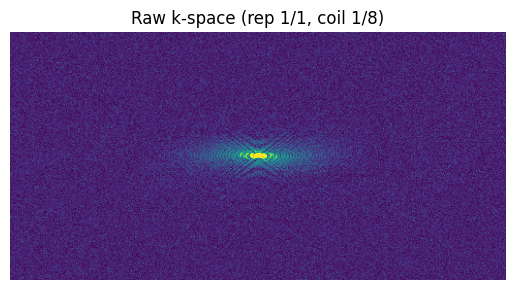

In [3]:
# Display the generated raw k-space data
import h5py
import ismrmrd
import numpy as np
import matplotlib.pyplot as plt

datasetName = 'dataset'

# List all datasets in the file
with h5py.File(inputFilename, 'r') as d:
    dsetNames = d.keys()
    print('File "%s" contains %d datasets:' % (inputFilename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[0]

    datasetName = list(d.keys())[0]

print('Reading dataset "%s" from file "%s"' % (datasetName, inputFilename))
dset = ismrmrd.Dataset(inputFilename, datasetName, False)

# Read MRD header
xmlHeader = dset.read_xml_header().decode('utf-8')
mrdHeader = ismrmrd.xsd.CreateFromDocument(xmlHeader)

# Get all readouts
acqs = [dset.read_acquisition(idx) for idx in range(dset.number_of_acquisitions())]

# Limit to imaging (non-noise) readouts
imgAcqs = [acq for acq in acqs if not acq.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT)]

print('There are %d imaging readouts out of a total of %d readouts' % (len(imgAcqs), dset.number_of_acquisitions()))

# Close file
dset.close()

# Format data into single [cha PE RO rep] array
lin = [acq.idx.kspace_encode_step_1 for acq in imgAcqs]
rep = [acq.idx.repetition           for acq in imgAcqs]

raw = np.zeros((mrdHeader.acquisitionSystemInformation.receiverChannels, 
                mrdHeader.encoding[0].encodedSpace.matrixSize.y, 
                mrdHeader.encoding[0].encodedSpace.matrixSize.x, 
                mrdHeader.encoding[0].encodingLimits.repetition.maximum+1), 
                imgAcqs[0].data.dtype)

for acq, lin, rep in zip(imgAcqs, lin, rep):
    raw[:,lin,-acq.data.shape[1]:,rep] = acq.data

# Show k-space
plt.imshow(np.abs(raw[0,:,:,0]), vmax=np.max(np.abs(raw[0,:,:,0]))*0.1)
plt.title('Raw k-space (rep %d/%d, coil %d/%d)' % (1, mrdHeader.encoding[0].encodingLimits.repetition.maximum+1, 1, mrdHeader.acquisitionSystemInformation.receiverChannels))
plt.axis('off')
plt.show()


# Run reconstruction
Algorithms/reconstructions are run as modules by the server component, which implements the [MRD streaming protocol](https://ismrmrd.readthedocs.io/en/latest/mrd_streaming_protocol.html).  The server must be started separately and a client sends data to the server for processing.  The server can be started via command line by running `python main.py`.

If using Visual Studio Code, [launch.json](../.vscode/launch.json) includes a debug configuration to run the server and allow for interactive debugging.  Click on the "Run and Debug" tab on the top left, then click the green play button to start the desired config ("Start server"):

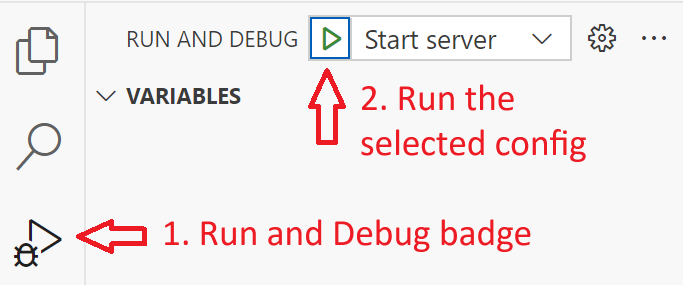

Breakpoints can be set by clicking to the left of the line number in a Python file:

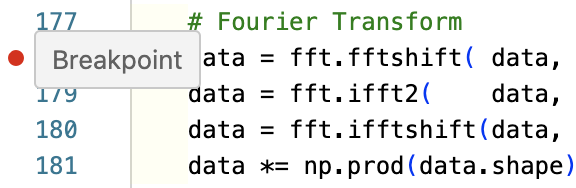

After the server is started, begin the reconstruction by running [client.py](../client.py) on the input dataset.  The recon code/module is selected by using the `config` argument.  The output is stored in a separate MRD file under a dataset named with the current date/time.

In [4]:
# Run reconstruction
import client
from types import SimpleNamespace

outputFilename = 'recon.mrd'

# Specify client arguments for recon
args = SimpleNamespace(**client.defaults)
args.config   = 'invertcontrast'  # Recon module to be used
args.outfile  = outputFilename
args.filename = inputFilename

client.main(args)

  dataset


/usr/local/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=5773) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


The output is an [HDF5-formatted file](https://www.hdfgroup.org/downloads/hdfview/) that is organized in the [MRD file format](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html).  It can be opened using MRD toolboxes for [python](https://github.com/ismrmrd/ismrmrd-python) or [MATLAB](https://github.com/ismrmrd/ismrmrd/tree/master/matlab/%2Bismrmrd) or the [ismrmrdviewer](https://github.com/ismrmrd/ismrmrdviewer).  The client can be run multiple times with the same output file and results are grouped by dataset.

File recon.mrd contains 1 groups (reconstruction runs):
  2024-02-15 07:06:02.639945
Group 2024-02-15 07:06:02.639945 contains 1 image series:
  images_0


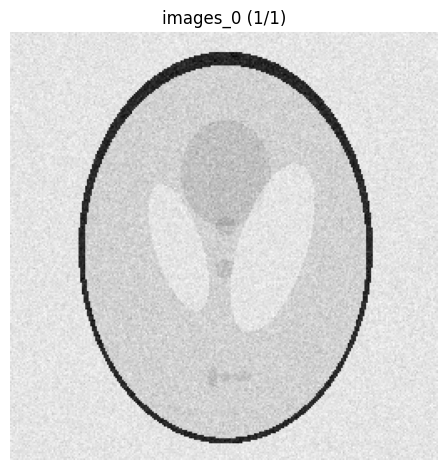

In [5]:
# Display the reconstructed images
import h5py
import mrdhelper

# If run multiple times, the recon.mrd file will have multiple reconstructed images
# Find the most recent recon run
with h5py.File(outputFilename, 'r') as d:
    dsetNames = d.keys()
    print('File %s contains %d groups (reconstruction runs):' % (outputFilename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[-1]

dset = ismrmrd.Dataset(outputFilename, group, False)
subgroups = dset.list()

# Images are organized by series number in subgroups that start with 'images_'
imgGroups = [group for group in list(subgroups) if (group.find('images_') != -1)]
print('Group %s contains %d image series:' % (group, len(imgGroups)))
print(' ', '\n  '.join(imgGroups))

# Show images
fig, axs = plt.subplots(1, len(imgGroups), squeeze=False)

for i, series in enumerate(imgGroups):
    n = dset.number_of_images(series)
    img = dset.read_image(series, 0)
    axs[0][i].imshow(np.squeeze(img.data), cmap='gray')
    axs[0][i].set_title(series + ' (1/' + str(n) + ')')
    axs[0][i].axis('off')
    axs[0][i].set_aspect('equal')

    # Read and plot ROIs
    meta = ismrmrd.Meta.deserialize(img.attribute_string)
    for key in meta.keys():
        if not key.startswith('ROI_'):
            continue

        roi = meta[key]
        x, y, rgb, thickness, style, visibility = mrdhelper.parse_roi(roi)

        if visibility == 0:
            continue

        lstyle = '-' if (style == 0) else '--'
        axs[0][i].plot(x, y, color=rgb, linewidth=thickness, linestyle=lstyle)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()
dset.close()